### Import Libaries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer
import xgboost as xgb

### Bring/Transform Data 

In [18]:
start_date = '2020-01-01'
# today_date = datetime.today().strftime('%Y-%m-%d')
# print(f"the data span from {start_date} up to {today_date}")

# fed effective interest rate
fed_rates = pd.read_excel('data/fed_eff_rate_2010-24.xlsx',sheet_name='Daily, 7-Day')
fed_rates.columns = ['date','rate']
fed_rates['date'] = pd.to_datetime(fed_rates['date'])
fed_rates['rate_change'] = fed_rates['rate'].diff()
fed_rates.head()
fed_rates = fed_rates.query('date > @start_date')

# EURO USD 
eurusd = yf.download('EURUSD=X', start=start_date)
eurusd = eurusd.reset_index()
eurusd.columns = ['date','open','high','low','eurusd_close','Adj Close','Volume']
eurusd = eurusd[['date','eurusd_close']]
eurusd.head()
eurusd['eurusd_change'] = eurusd['eurusd_close'].diff()

# zf 
df = yf.download('ZF=F', start=start_date)
df.reset_index(inplace=True)

# unemployment monthly 
unemployment_rate = pd.read_excel('data/UNRATE.xlsx', 'Monthly')
unemployment_rate.columns = ['date','un_rate']
unemployment_rate['date'] = pd.to_datetime(unemployment_rate['date'])
unemployment_rate = unemployment_rate.set_index('date').resample('D').ffill().reset_index()
unemployment_rate['un_change'] = unemployment_rate['un_rate'].diff()

### vix
vix = yf.download('^VIX', start=start_date)
vix.reset_index(inplace=True)
vix['vix_change'] = vix['Close'].diff()
vix = vix[['Date','vix_change','Close']]
vix.columns = ['date','vix_change','vix_close']

# snp500
sp500 = yf.download('^GSPC', start=start_date)
sp500.reset_index(inplace=True)
sp500['sp500_change'] = sp500['Close'].diff()
sp500 = sp500[['Date','sp500_change','Close']]
sp500.columns = ['date','sp500_change','sp500_close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [19]:
df.columns = ['date','open','high','low','close','close_x','zf_volume']
del df['close_x']

### Feature Engineering

In [20]:
# candle stick features 
df['high_low'] = df['high'] - df['low']
df['body'] = df['close'] - df['open']
df['zf_change'] = df['close'].diff()
df['zf_change_pct'] = df['zf_change'] * 100

# Calendar features
df["day_of_week"] = df['date'].dt.dayofweek
df["day_of_month"] = df['date'].dt.day
df["week_of_year"] = df['date'].dt.isocalendar().week
df["month"] = df['date'].dt.month
df["year"] = df['date'].dt.year
df["quarter"] = df['date'].dt.quarter
df["is_month_end"] = df['date'].dt.is_month_end.astype(int)
df["is_month_start"] = df['date'].dt.is_month_start.astype(int)

# target 
df['tomorrow'] = df['close'].shift(-1)
df['target'] = (df['tomorrow'] > df['close']).astype(int)

In [21]:
df.head()

,date,open,high,low,close,zf_volume,high_low,body,zf_change,zf_change_pct,day_of_week,day_of_month,week_of_year,month,year,quarter,is_month_end,is_month_start,tomorrow,target
0,2020-01-02,118.531250,118.851562,118.460938,118.664062,736650,0.390625,0.132812,NaN,NaN,3,2,1,1,2020,1,0,0,119.062500,1
1,2020-01-03,118.679688,119.109375,118.671875,119.062500,868998,0.437500,0.382812,0.398438,39.84375,4,3,1,1,2020,1,0,0,118.960938,0
2,2020-01-06,119.101562,119.210938,118.898438,118.960938,859162,0.312500,-0.140625,-0.101562,-10.15625,0,6,2,1,2020,1,0,0,118.921875,0
3,2020-01-07,118.953125,119.046875,118.906250,118.921875,746424,0.140625,-0.031250,-0.039062,-3.90625,1,7,2,1,2020,1,0,0,118.695312,0
4,2020-01-08,118.976562,119.523438,118.679688,118.695312,1225252,0.843750,-0.281250,-0.226562,-22.65625,2,8,2,1,2020,1,0,0,118.742188,1


In [22]:
full_df = df.merge(fed_rates, on='date', how='left')
full_df = full_df.dropna()

In [23]:
full_df.target.value_counts()

0    650
1    601
Name: target, dtype: int64

In [24]:
## merge datasets 
full_df = full_df.merge(eurusd, on='date',how='left')
full_df = full_df.merge(unemployment_rate,on='date',how='left')
full_df = full_df.merge(sp500, on='date',how='left')
full_df = full_df.merge(vix, on='date',how='left')
full_df['is_rate_change'] =  (full_df['rate_change'] != full_df['rate_change'].shift()).astype(int)
full_df['is_rate_change'] = full_df['is_rate_change'].rolling(window=5, center=True, min_periods=1).max().astype(int)
full_df['is_un_change'] = (full_df['un_change'] != full_df['un_change'].shift()).astype(int)
full_df['is_un_change'] = full_df['is_un_change'].rolling(window=5, center=True, min_periods=1).max().astype(int)


In [25]:
full_df, ohcl_predictors = create_ohlc_features(full_df)


/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_2599/2214281715.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  rolling_averages = df.rolling(horizon).mean()
/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_2599/2214281715.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  rolling_averages = df.rolling(horizon).mean()
/var/folders/m8/yxnbqbdj74l_yx0j7kns7hhh0000gp/T/ipykernel_2599/2214281715.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dro

### Modeling

In [26]:
full_df.columns

Index(['date', 'open', 'high', 'low', 'close', 'zf_volume', 'high_low', 'body',
       'zf_change', 'zf_change_pct', 'day_of_week', 'day_of_month',
       'week_of_year', 'month', 'year', 'quarter', 'is_month_end',
       'is_month_start', 'tomorrow', 'target', 'rate', 'rate_change',
       'eurusd_close', 'eurusd_change', 'un_rate', 'un_change', 'sp500_change',
       'sp500_close', 'vix_change', 'vix_close', 'is_rate_change',
       'is_un_change', 'Close_Ratio_2', 'Trend_2', 'Volatility_2',
       'Momentum_2', 'Cumulative_Return_2', 'Close_Ratio_5', 'Trend_5',
       'Volatility_5', 'Momentum_5', 'Cumulative_Return_5', 'Close_Ratio_10',
       'Trend_10', 'Volatility_10', 'Momentum_10', 'Cumulative_Return_10',
       'Close_Ratio_15', 'Trend_15', 'Volatility_15', 'Momentum_15',
       'Cumulative_Return_15', 'Close_Ratio_20', 'Trend_20', 'Volatility_20',
       'Momentum_20', 'Cumulative_Return_20', 'Close_Ratio_40', 'Trend_40',
       'Volatility_40', 'Momentum_40', 'Cumulative_Re

In [27]:
full_df = full_df.dropna()

full_df.shape

(1157, 67)

In [28]:
predictors = ['high_low', 'body', 'zf_change',
       'zf_change_pct', 'zf_volume','day_of_week', 'day_of_month', 'week_of_year', 'month',
       'year', 'quarter', 'is_month_end', 'is_month_start',
        'rate', 'rate_change', 'eurusd_change','eurusd_close', 'un_rate',
       'un_change','sp500_change','sp500_close',
#               'is_rate_change',
#               'is_un_change',
              'vix_change','vix_close']
predictors = predictors + ohcl_predictors
target = 'target'

In [29]:
predictors

['high_low',
 'body',
 'zf_change',
 'zf_change_pct',
 'zf_volume',
 'day_of_week',
 'day_of_month',
 'week_of_year',
 'month',
 'year',
 'quarter',
 'is_month_end',
 'is_month_start',
 'rate',
 'rate_change',
 'eurusd_change',
 'eurusd_close',
 'un_rate',
 'un_change',
 'sp500_change',
 'sp500_close',
 'vix_change',
 'vix_close',
 'Close_Ratio_2',
 'Trend_2',
 'Volatility_2',
 'Momentum_2',
 'Cumulative_Return_2',
 'Close_Ratio_5',
 'Trend_5',
 'Volatility_5',
 'Momentum_5',
 'Cumulative_Return_5',
 'Close_Ratio_10',
 'Trend_10',
 'Volatility_10',
 'Momentum_10',
 'Cumulative_Return_10',
 'Close_Ratio_15',
 'Trend_15',
 'Volatility_15',
 'Momentum_15',
 'Cumulative_Return_15',
 'Close_Ratio_20',
 'Trend_20',
 'Volatility_20',
 'Momentum_20',
 'Cumulative_Return_20',
 'Close_Ratio_40',
 'Trend_40',
 'Volatility_40',
 'Momentum_40',
 'Cumulative_Return_40',
 'Close_Ratio_60',
 'Trend_60',
 'Volatility_60',
 'Momentum_60',
 'Cumulative_Return_60']

In [30]:
# Convert categorical columns to numeric or use `enable_categorical=True`
# X = full_df[predictors].copy()
# y = full_df[target]
X = full_df.copy()
X = X.query('is_rate_change == 1 or is_un_change==1')
del X['is_rate_change'], X['is_un_change']
for col in X.columns:
    if X[col].dtype.name not in ['int64', 'float64', 'bool']:
        if pd.api.types.is_categorical_dtype(X[col]) or pd.api.types.is_object_dtype(X[col]):
            X[col] = X[col].astype('category').cat.codes  # Convert to category codes
        elif pd.api.types.is_datetime64_any_dtype(X[col]):  # Handle datetime columns
            # Example: Convert datetime to a numeric format (e.g., timestamp)
            X[col] = X[col].astype('int64') // 10**9  # Convert to seconds since epoch
        else:
            X[col] = X[col].astype('float64')  # Convert UInt32 or others to float

In [31]:
X.shape

(418, 65)

### XGBoost

In [32]:
# # Splitting data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train XGBoost Classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# model.fit(X_train, y_train)

# # Predictions and Precision
# y_pred = model.predict(X_test)
# precision = precision_score(y_test, y_pred)
# print(f"Precision: {precision}")

predictions = backtest(X, model, predictors)
precision_score(predictions["target"], predictions["Predictions"])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0.5783132530120482

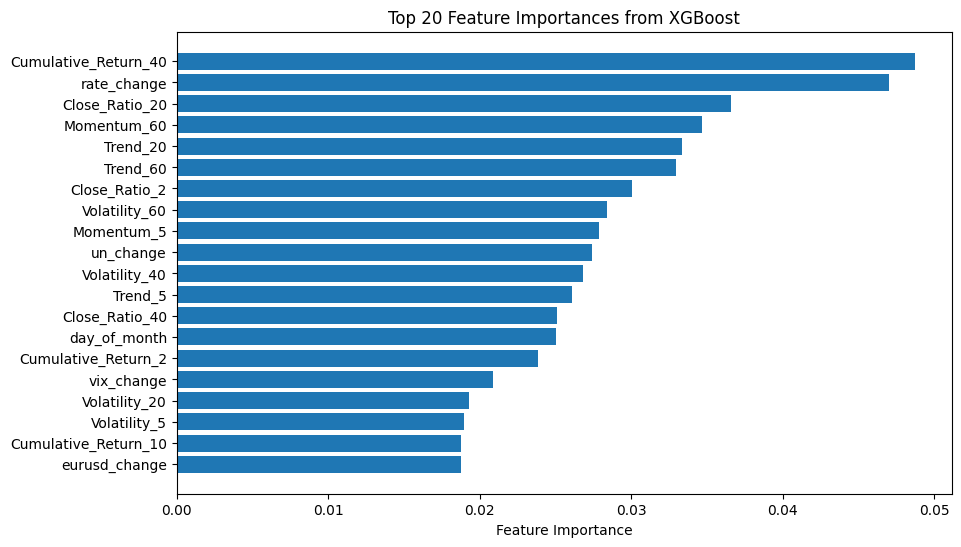

In [33]:
# Feature Importances
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Select the top 15 features
top_n = 20
top_features = sorted_idx[:top_n]

plt.figure(figsize=(10, 6))
plt.barh([predictors[i] for i in top_features], importances[top_features])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Feature Importances from XGBoost")
plt.gca().invert_yaxis()
plt.show()

In [34]:
predictions["target"].value_counts() / predictions.shape[0]

1    0.541667
0    0.458333
Name: target, dtype: float64

### Feature Selection

In [37]:
# Perform iterative feature selection
step_size = 5
results_df, selected_features = iterative_feature_selection(X, model, predictors, step_size)

# Display results
print(results_df)

Step: 5, Precision: 0.5862068965517241
Step: 10, Precision: 0.59375
Step: 15, Precision: 0.5520833333333334
Step: 20, Precision: 0.5825242718446602
Step: 25, Precision: 0.573170731707317
Step: 30, Precision: 0.6197183098591549
Step: 35, Precision: 0.5465116279069767
Step: 40, Precision: 0.5862068965517241
Step: 45, Precision: 0.573170731707317
Step: 50, Precision: 0.5365853658536586
Step: 55, Precision: 0.5679012345679012
    Num Features  Precision
0              5   0.586207
1             10   0.593750
2             15   0.552083
3             20   0.582524
4             25   0.573171
5             30   0.619718
6             35   0.546512
7             40   0.586207
8             45   0.573171
9             50   0.536585
10            55   0.567901


In [38]:
selected_features.sort_values(ascending=False, by='Average_Importance')

,Feature,Importance,Cumulative_Importance,Counts,Average_Importance
56,Momentum_60,0.044124,0.754900,11,0.068627
48,Close_Ratio_40,0.036948,0.707413,11,0.064310
6,day_of_month,0.032149,0.694221,11,0.063111
8,month,0.033159,0.603310,11,0.054846
44,Trend_20,0.025229,0.532817,10,0.053282
46,Momentum_20,0.038400,0.563718,11,0.051247
37,Cumulative_Return_10,0.023734,0.435351,9,0.048372
36,Momentum_10,0.028800,0.432771,10,0.043277
29,Trend_5,0.025941,0.408369,10,0.040837
50,Volatility_40,0.029420,0.393269,10,0.039327


### Helpers

In [8]:
def create_ohlc_features(df, horizons=[2, 5, 10, 15, 20,40,60]):
    predictors = []

    for horizon in horizons:
        # Rolling averages and ratios
        rolling_averages = df.rolling(horizon).mean()
        df[f"Close_Ratio_{horizon}"] = df["close"] / rolling_averages["close"]
        # Trend (cumulative sum of target over horizon)
        df[f"Trend_{horizon}"] = df["target"].shift(1).rolling(horizon).sum()

        # Volatility (rolling standard deviation)
        df[f"Volatility_{horizon}"] = df["close"].rolling(horizon).std()

        # Momentum (difference between current and lagged price)
        df[f"Momentum_{horizon}"] = df["close"] - df["close"].shift(horizon)


        # Cumulative Return
        df[f"Cumulative_Return_{horizon}"] = df["close"].pct_change().rolling(horizon).sum()

        # Add features to the predictor list
        predictors += [
            f"Close_Ratio_{horizon}",
            f"Trend_{horizon}",
            f"Volatility_{horizon}",
            f"Momentum_{horizon}",
            f"Cumulative_Return_{horizon}",
        ]

    # Drop NA rows introduced by rolling and shifting, but only drop rows with all NaNs
    df = df.dropna(subset=predictors, how="all")

    return df, predictors


def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=250, step=20):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

def backtest_around_announcements(data, model, predictors, start=250, step=20):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Train and predict
        predictions = predict(train, test, predictors, model)
        predictions = predictions.join(data[["is_rate_change"]], how="left")
        predictions = predictions.join(data[["is_un_change"]], how="left")
        
        # Append all predictions for later evaluation
        all_predictions.append(predictions)
    
    # Combine results
    combined_predictions = pd.concat(all_predictions)
    
    # Filter only rows where is_rate_change == 1
#     announcement_predictions = combined_predictions[combined_predictions["is_rate_change"] == 1]
    announcement_predictions = combined_predictions.query('is_rate_change == 1 or is_un_change==1')
    return announcement_predictions


def iterative_feature_selection(data, model, predictors, step_size):
    # Fit the model to get initial feature importances
    model.fit(data[predictors], data["target"])
    initial_importances = model.feature_importances_
    
    # Create a DataFrame to hold aggregated feature importances
    feature_importance_df = pd.DataFrame({
        "Feature": predictors,
        "Importance": initial_importances
    }).set_index("Feature")
    feature_importance_df["Cumulative_Importance"] = 0
    feature_importance_df["Counts"] = 0

    # Iteratively evaluate features
    results = []
    step = step_size

    while step <= len(predictors):
        # Get the top `step` features
        top_features = feature_importance_df.sort_values(by="Importance", ascending=False).index[:step].tolist()

        # Backtest with the selected features
        predictions = backtest(data, model, top_features)
        precision = precision_score(predictions["target"], predictions["Predictions"])

        # Update feature importances for the current top features
        model.fit(data[top_features], data["target"])
        current_importances = model.feature_importances_
        for feature, importance in zip(top_features, current_importances):
            feature_importance_df.loc[feature, "Cumulative_Importance"] += importance
            feature_importance_df.loc[feature, "Counts"] += 1

        # Store results
        results.append({"Num Features": step, "Precision": precision})
        print(f"Step: {step}, Precision: {precision}")
        
        # Increment the step size
        step += step_size

    # Finalize aggregated importances
    feature_importance_df["Average_Importance"] = (
        feature_importance_df["Cumulative_Importance"] / feature_importance_df["Counts"]
    ).fillna(0)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df, feature_importance_df.reset_index()
